## Set up dataset

In [ ]:
data_dir = './data'
norm = 'L2'
epsilon = 0.5
model_path = './resnet50_cifar10_Epc_20.pt'
n_ex = 10000
individual = False
save_dir = './results'
batch_size = 500
log_path = './log_file.txt'
version = 'standard'
state_path = None


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from torchvision.models import resnet50
import tensorflow as tf
import torch as ch
from robustness.datasets import CIFAR
from robustness.tools.vis_tools import show_image_row
from robustness.attacker import AttackerModel

In [ ]:
ATTACK_EPS = 0.5
ATTACK_STEPSIZE = 0.1
ATTACK_STEPS = 10
NUM_WORKERS = 8
BATCH_SIZE = 10

In [ ]:
import torch as ch
from robustness.datasets import CIFAR
ds = CIFAR('/tmp')

In [ ]:
from robustness.datasets import CINIC

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Instantiate model

In [ ]:
#dataset robustification

In [ ]:
from robustness.model_utils import make_and_restore_model
model_CINIC, _ = make_and_restore_model(arch='resnet50', dataset=ds,
             resume_path='illusionary robust features/cifar_l2_0_5.pt')
model_CINIC.eval()
pass


=> loading checkpoint '/data/leuven/352/vsc35276/robust/illusionary robust features/cifar_l2_0_5.pt'
=> loaded checkpoint '/data/leuven/352/vsc35276/robust/illusionary robust features/cifar_l2_0_5.pt' (epoch 153)


In [ ]:
# Load data
# Step 1: Define the directory where CINIC-10 is stored
data_dir = 'robust/illusionary robust features/CINIC/'

# Step 2: Define the data transformations
transform_list = [transforms.ToTensor()]  # Add more transformations as needed
transform_chain = transforms.Compose(transform_list)

# Step 3: Load the test dataset
test_dataset = ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform_chain)

# Step 4: Create a DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=1)

In [ ]:

ds = CIFAR('/tmp')

# Instantiate the defender model
defender_model, _ = make_and_restore_model(arch='resnet50', dataset=ds,
             resume_path='C:/Users/32456/robust/newest/Cifar AT model/cifar_l2_0_5(Done).pt')
defender_model.eval()


# Set up loaders
NUM_WORKERS = 8
BATCH_SIZE = 10
_, test_loader = ds.make_loaders(workers=NUM_WORKERS, batch_size=BATCH_SIZE)

In [ ]:
from robustness.datasets import CINIC

data_path = "illusionary robust features/CINIC"  # Path to your CINIC-10 dataset
cinic_dataset = CINIC(data_path)

# Load your data loaders
train_loader, test_loader = cinic_dataset.make_loaders(workers=NUM_WORKERS, batch_size=BATCH_SIZE)
_, (im, label) = next(enumerate(test_loader))

==> Preparing dataset cinic..


In [ ]:
# Load saved data
saved_data_path = f'{save_dir}/aa_{version}_1_{n_ex}_eps_{epsilon:.5f}_SS.pth'
loaded_data = torch.load(saved_data_path)

# Access the loaded data
adv_complete_loaded_SS = loaded_data['adv_complete']

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# Load CIFAR-10 data to get the labels
data_dir = './data'
transform_list = [transforms.ToTensor()]
transform_chain = transforms.Compose(transform_list)
cifar_test_dataset = datasets.CIFAR10(root=data_dir, train=False, transform=transform_chain, download=True)
test_loader = torch.utils.data.DataLoader(cifar_test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Retrieve the original labels from CIFAR-10
l = [y for (x, y) in test_loader]
y_test = torch.cat(l, 0)  # CIFAR-10 labels for all test images

# Assuming adv_complete_loaded_SS contains the adversarial examples
adv_images = adv_complete_loaded_SS  # Contains the adversarial images

# Use CIFAR-10 labels for adversarial examples
adv_labels = y_test[:len(adv_images)]  # Ensure labels match the number of adversarial examples

# Step 1: Create a custom Dataset class
class AdversarialDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Step 2: Initialize the Dataset with adversarial examples and CIFAR-10 labels
adv_dataset = AdversarialDataset(adv_images, adv_labels)

# Step 3: Create a DataLoader
BATCH_SIZE = 5000 # Adjust as needed
adv_loader = DataLoader(adv_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Step 4: Iterate over the DataLoader (example to fetch one batch)
_, (im_inv, label_inv) = next(enumerate(adv_loader))

# 'im' will be the batch of adversarial images, and 'label' will be the corresponding labels
print(im_inv.shape, label_inv.shape)  # Check shapes


Files already downloaded and verified
torch.Size([5000, 3, 32, 32]) torch.Size([5000])


In [ ]:
#first of all accuracy

In [ ]:
# Define the evaluation function to compute accuracy
def evaluate(model, data_loader):
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    # Move the model to the device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: get model predictions (unpack the tuple)
            outputs, _ = model(inputs)  # Unpack to get logits, ignoring additional metadata
            loss = criterion(outputs, labels)

            # Calculate the loss
            total_loss += loss.item()

            # Get the predicted classes
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute accuracy and average loss
    accuracy = correct / total
    avg_loss = total_loss / total
    return accuracy, avg_loss


# Evaluate the model on the test set
test_accuracy, test_loss = evaluate(model_CINIC, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 0.7137
Test Loss: 0.1024


In [ ]:
#first untargeted attack

In [ ]:
kwargs = {
    'constraint':'2', # use L2-PGD
    'eps': ATTACK_EPS, # L2 radius around original image
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'do_tqdm': True,
}

In [ ]:
model_CINIC = model_CINIC.to(device)

In [ ]:
im = im.to(device)  # Move the input image to the correct device
label = label.to(device)  # Move the label to the correct device

In [ ]:
_, im_adv = model_CINIC(im, label, make_adv=True, **kwargs)


Current loss: 2.0984275341033936: 100%|██████████| 10/10 [00:00<00:00, 14.68it/s]


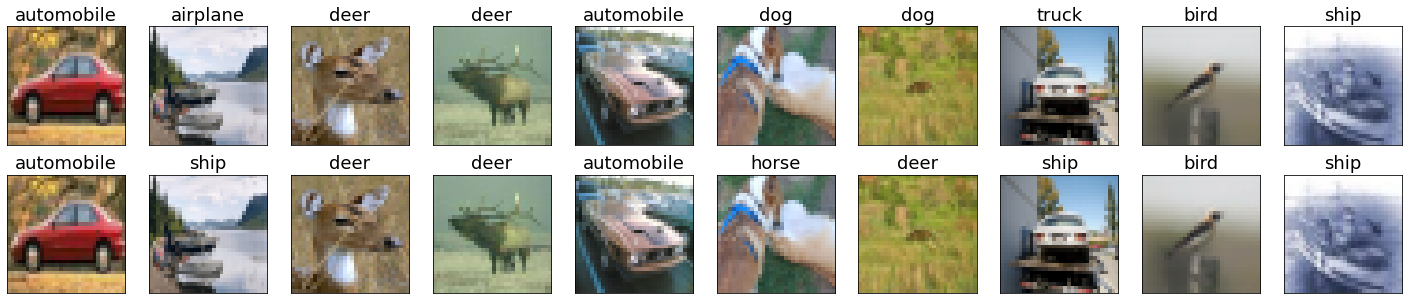

In [ ]:
from robustness.tools.vis_tools import show_image_row
from robustness.tools.label_maps import CLASS_DICT

# Get predicted labels for adversarial examples
pred, _ = model_CINIC(im_adv)
label_pred = ch.argmax(pred, dim=1)

# Visualize test set images, along with corresponding adversarial examples
show_image_row([im.cpu(), im_adv.cpu()],
         tlist=[[CLASS_DICT['CIFAR'][int(t)] for t in l] for l in [label, label_pred]],
         fontsize=18,
         filename='./adversarial_example_CINIC.png')

In [ ]:
#targeted attack

In [ ]:
kwargs = {
    'constraint':'2',
    'eps': ATTACK_EPS,
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'targeted': True,
    'do_tqdm': True
}

In [ ]:
targ = ch.zeros_like(label)


In [ ]:
_, im_adv = model_CINIC(im, targ, make_adv=True, **kwargs)


Current loss: 3.835688352584839: 100%|██████████| 10/10 [00:00<00:00, 14.68it/s]


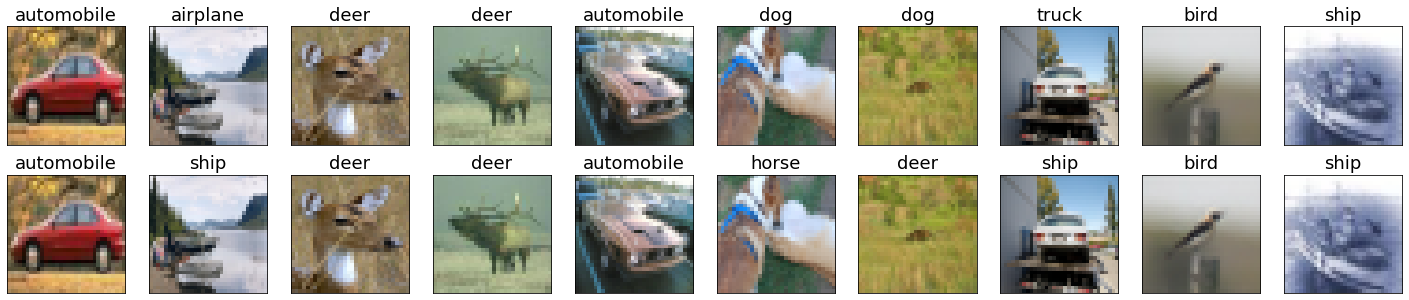

In [ ]:
# Visualize test set images, along with corresponding adversarial examples
show_image_row([im.cpu(), im_adv.cpu()],
         tlist=[[CLASS_DICT['CIFAR'][int(t)] for t in l] for l in [label, label_pred]],
         fontsize=18,
         filename='./adversarial_example_CINIC.png')

In [ ]:
#Custom Input Manipulation (Representation Inversion)


In [ ]:
def inversion_loss(model, inp, targ):
    # Compute representation for the input
    _, rep = model(inp, with_latent=True, fake_relu=True)
    # Normalized L2 error w.r.t. the target representation
    loss = ch.div(ch.norm(rep - targ, dim=1), ch.norm(targ, dim=1))
    return loss, None

In [ ]:
kwargs = {
    'custom_loss': inversion_loss,
    'constraint':'2',
    'eps': 1000,
    'step_size': 1,
    'iterations': 1000,
    'targeted': True,
    'do_tqdm': True,
}

In [ ]:
im_seed = ch.clamp(ch.randn_like(im_inv) / 20 + 0.5, 0, 1)


In [ ]:
_, im_matched = model_CINIC(im_seed.to(device), rep_inv.to(device), make_adv=True, **kwargs)


Current loss: 0.08878862112760544: 100%|██████████| 1000/1000 [00:40<00:00, 24.67it/s]


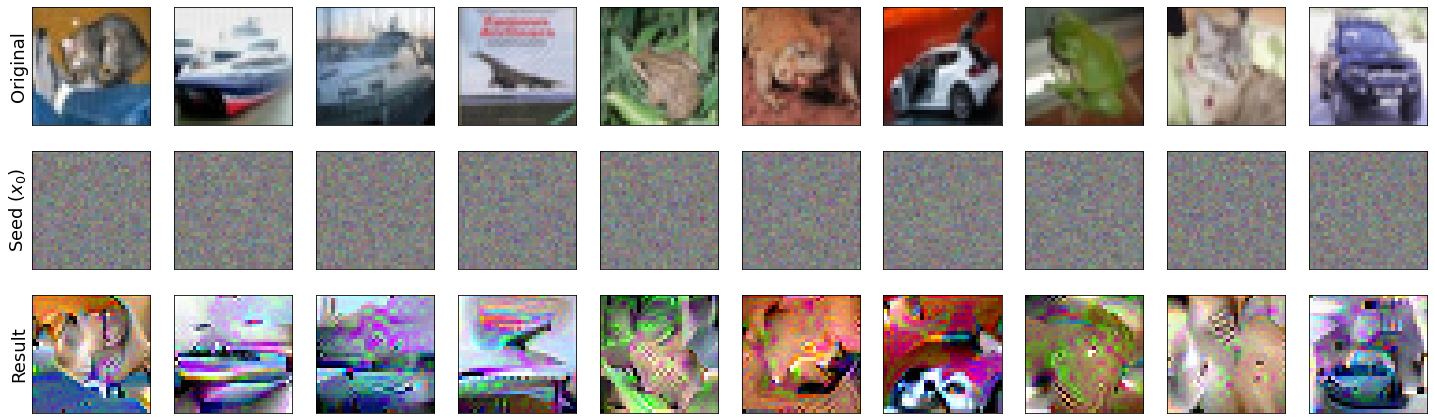

In [ ]:
show_image_row([im_inv.cpu(), im_seed.cpu(), im_matched.cpu()],
         ["Original", r"Seed ($x_0$)", "Result"],
         fontsize=18,
         filename='./custom_inversion_CINIC.png')

In [ ]:
robustified_images = ch.zeros_like(im_inv)

# Loop over in steps of 10 for batch processing
for t in range(0, 5*1000, 10):
    end_idx = min(t + 10, len(im_inv))  # Ensure no out-of-bounds indexing
    im_batch = im_inv[t:end_idx].to(device)
    seed_batch = im_seed[t:end_idx].to(device)

    with ch.no_grad():
        # Get the corresponding representation
        (_, rep_inv), _ = model_CINIC(im_batch, with_latent=True)

    # Generate adversarially matched images using the representation
    _, im_matched = model_CINIC(seed_batch, rep_inv.to(device), make_adv=True, **kwargs)

    # Store robustified images
    robustified_images[t:end_idx] = im_matched


Current loss: 0.11103437095880508:  93%|█████████▎| 927/1000 [00:38<00:03, 24.12it/s]

In [ ]:
df = numpy.save("rar_SS", robustified_images.cpu().numpy())
loaded_array = np.load('rar_SS.npy')
loaded_array.shape

In [ ]:
df = numpy.save("rar_SS.l", label_inv.cpu().numpy())
label_inv_array = np.load('rar_SS.l.npy')
label_inv_array.shape

In [ ]:
#real robustification

In [ ]:
from robustness.datasets import CINIC

data_path = "illusionary robust features/CINIC"  # Path to your CINIC-10 dataset
cinic_dataset = CINIC(data_path)

# Load your data loaders
train_loader, test_loader = cinic_dataset.make_loaders(workers=NUM_WORKERS, batch_size=BATCH_SIZE)

In [ ]:
from robustness.model_utils import make_and_restore_model
model_CINIC, _ = make_and_restore_model(arch='resnet50', dataset=ds,
             resume_path='cifar_l2_0_5.pt')
model_CINIC.eval()
pass

In [ ]:
# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attacker_model = models.resnet50(pretrained=False)
num_ftrs = attacker_model.fc.in_features
attacker_model.fc = nn.Linear(num_ftrs, 10)

loaded_attacker_model = models.resnet50(pretrained=False)
loaded_attacker_model.fc = nn.Linear(num_ftrs, 10)
loaded_attacker_model.load_state_dict(torch.load(r"illusionary robust features/resnet50_cifar10_model_incorrect_lable.pth"))
loaded_attacker_model = loaded_attacker_model.to(device)

In [ ]:
robustified_images = ch.zeros_like(im_inv)

# Loop over in steps of 10 for batch processing
for t in range(0, 5*1000, 10):
    end_idx = min(t + 10, len(im_inv))  # Ensure no out-of-bounds indexing
    im_batch = im_inv[t:end_idx].to(device)
    seed_batch = im_seed[t:end_idx].to(device)

    with ch.no_grad():
        # Get the corresponding representation
        (_, rep_inv), _ = model_CINIC(im_batch, with_latent=True)

    # Generate adversarially matched images using the representation
    _, im_matched = model_CINIC(seed_batch, rep_inv.to(device), make_adv=True, **kwargs)

    # Store robustified images
    robustified_images[t:end_idx] = im_matched


In [ ]:
df = numpy.save("rrar_SS", robustified_images.cpu().numpy())
loaded_array = np.load('rrar_SS.npy')
loaded_array.shape

In [ ]:
df = numpy.save("rrar_SS.l", label_inv.cpu().numpy())
label_inv_array = np.load('rrar_SS.l.npy')
label_inv_array.shape

In [ ]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from resnet import ResNet50

# Assuming you have already trained and saved your pure robust model
model = ResNet50()
model.load_state_dict(torch.load('resnet50_cifar10_rr.pt'))
#'resnet50_cifar10_Epc_20.pt'
#'resnet50_cifar10_Epc_20_r.pt'
#'resnet50_cifar10_rr.pt'
model.eval()

test_data = np.load('rrar_SS.npy')
test_data = torch.from_numpy(test_data).float()
test_label = np.load('rrar_SS.l.npy')
test_label = torch.from_numpy(test_label)

# Evaluate on adversarial examples
num_correct = 0

with torch.no_grad():
    for i in range(5000):
        input_image, target = test_data[i], test_label[i]
        input_image = input_image.unsqueeze(0)  # Add batch dimension

        # Forward pass
        output = model(input_image)
        _, predicted = torch.max(output.data, 1)

        # Check accuracy
        if predicted.item() == target:
            num_correct += 1

# Calculate accuracy
accuracy = num_correct / 5000
print("Accuracy on Adversarial Examples: {:.2%}".format(accuracy))

Accuracy on Adversarial Examples: 76.62%


In [ ]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from resnet import ResNet50

# Assuming you have already trained and saved your model
model = ResNet50()
model.load_state_dict(torch.load('resnet50_cifar10_rr.pt'))
model.eval()

test_data = np.load('rrar_RRS.npy')
test_data = torch.from_numpy(test_data).float()
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform)


# Evaluate on adversarial examples
num_correct = 0

with torch.no_grad():
    for i in range(5000):
        input_image, target = adv_complete_loaded_RRS[i], cifar10_test.targets[:5000][i]
        input_image = input_image.unsqueeze(0)  # Add batch dimension

        # Forward pass
        output = model(input_image)
        _, predicted = torch.max(output.data, 1)

        # Check accuracy
        if predicted.item() == target:
            num_correct += 1

# Calculate accuracy
accuracy = num_correct / 5000
print("Accuracy on Adversarial Examples: {:.2%}".format(accuracy))